In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

8784


In [2]:
import cv2
from tqdm import tqdm

In [3]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2'

folders, fovs = ia.io_tools.data.get_folders(data_folder)

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 295


In [4]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [5]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed


# Part 2: watershed

In [9]:
for _fov_id, _fov_name in enumerate(fovs):
    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(ref_image_file, 
                                                  CorrectionFolder=correction_folder, 
                                                  DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, 
                                              DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488,405])
    _cls._corr_illumination()
    _cls.im_750 = _cls.im_750[0::4]
    _cls.im_488 = _cls.im_488[0::4]
    _cls.image_size = np.array(np.shape(_ref_im))
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(correction_channels=[750], corr_chromatic=False)

    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)

    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- seg file: {seg_save_file} has not been generated yet, skip. ")
        continue
        
    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, 1.6)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    #break

\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_0.npy already exists, skip
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_001.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_001.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_001.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.010s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.098s.
- Finished illumination correction in 1.186s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_001.dax
-- 

	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.656s.
-- corrected illumination for channel 488 in 4.766s.
-- corrected illumination for channel 405 in 4.688s.
- Finished illumination correction in 16.235s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -21.15  23.21] in 0.578s.
-- drift 1: [-1.000e-02 -2.115e+01  2.346e+01] in 0.594s.
-- drift 2: [  0.   -21.1   23.52] in 0.640s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-3.33333333e-03 -2.11333333e+01  2.33966667e+01] for channel: 750
-- finish warpping channel 750 in 16.406s.
-- finish warpping in 16.406s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_4.npy
- run watershed in 77.614s.
- save to

- Loaded images for channels:['488'] in 1.078s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.234s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_008.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.938s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.218s.
-- corrected illuminat

-- drift 0: [ -0.03 -20.56  26.6 ] in 0.580s.
-- drift 1: [ -0.04 -20.68  26.79] in 0.562s.
-- drift 2: [ -0.04 -20.54  26.63] in 0.625s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.03666667 -20.59333333  26.67333333] for channel: 750
-- finish warpping channel 750 in 16.352s.
-- finish warpping in 16.352s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_11.npy
- run watershed in 77.120s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_11.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_012.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_012.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_0

-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction in 1.218s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_015.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.204s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.282s.
-- corrected illumination for channel 488 in 4.218s.
-- corrected illumination for channel 405 in 4.235s.
- Finished illumination correction in 12.984s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[ 2.33333333e-02 -2.15566667e+01  3.00033333e+01] for channel: 750
-- finish warpping channel 750 in 16.358s.
-- finish warpping in 16.358s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_18.npy
- run watershed in 92.005s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_18.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_019.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_019.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_019.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.093s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loadi

- Loaded images for channels:['750', '488', '405'] in 2.861s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.219s.
-- corrected illumination for channel 488 in 4.296s.
-- corrected illumination for channel 405 in 4.261s.
- Finished illumination correction in 12.979s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.18 -21.77  28.41] in 0.682s.
-- drift 1: [ -0.15 -21.32  28.66] in 0.570s.
-- drift 2: [ -0.19 -21.32  28.67] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.17333333 -21.47      

- run watershed in 71.711s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_25.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_026.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_026.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_026.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.109s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.172s.
- Finished illumination correction in 1.187s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M1

-- corrected illumination for channel 750 in 4.220s.
-- corrected illumination for channel 488 in 4.317s.
-- corrected illumination for channel 405 in 4.531s.
- Finished illumination correction in 13.178s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -20.98  25.1 ] in 0.594s.
-- drift 1: [ -0.03 -21.18  25.35] in 0.640s.
-- drift 2: [ -0.03 -21.25  25.23] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-2.00000000e-02 -2.11366667e+01  2.52266667e+01] for channel: 750
-- finish warpping channel 750 in 16.319s.
-- finish warpping in 16.319s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_29.npy
- run watershed in 85.237s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_

- Loaded images for channels:['488'] in 0.950s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.114s.
- Finished illumination correction in 1.160s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_033.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.708s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.390s.
-- corrected illuminat

-- drift 0: [-1.000e-02 -2.167e+01  2.092e+01] in 0.570s.
-- drift 1: [-1.000e-02 -2.163e+01  2.114e+01] in 0.614s.
-- drift 2: [ -0.03 -21.57  21.06] in 0.694s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.66666667e-02 -2.16233333e+01  2.10400000e+01] for channel: 750
-- finish warpping channel 750 in 16.495s.
-- finish warpping in 16.495s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_36.npy
- run watershed in 93.759s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_36.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_037.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_037.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-h

-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_040.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.603s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.235s.
-- corrected illumination for channel 488 in 4.282s.
-- corrected illumination for channel 405 in 4.328s.
- Finished illumination correction in 13.018s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[ -0.04       -23.02        24.49666667] for channel: 750
-- finish warpping channel 750 in 16.467s.
-- finish warpping in 16.467s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_43.npy
- run watershed in 89.343s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_43.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_044.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_044.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_044.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumi

- Loaded images for channels:['750', '488', '405'] in 2.818s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.203s.
-- corrected illumination for channel 488 in 4.344s.
-- corrected illumination for channel 405 in 4.483s.
- Finished illumination correction in 13.171s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.13 -20.64  20.43] in 0.609s.
-- drift 1: [ -0.06 -20.51  20.64] in 0.595s.
-- drift 2: [ -0.13 -20.6   20.5 ] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.10666667 -20.58333333

- run watershed in 90.851s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_50.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_051.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_051.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_051.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.002s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M1

-- corrected illumination for channel 750 in 4.438s.
-- corrected illumination for channel 488 in 4.391s.
-- corrected illumination for channel 405 in 4.311s.
- Finished illumination correction in 13.359s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -2.172e+01  2.201e+01] in 0.609s.
-- drift 1: [ 2.000e-02 -2.171e+01  2.213e+01] in 0.548s.
-- drift 2: [  0.03 -21.67  22.01] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 2.000e-02 -2.170e+01  2.205e+01] for channel: 750
-- finish warpping channel 750 in 16.314s.
-- finish warpping in 16.314s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_54.npy
- run watershed in 99.390s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentati

- Loaded images for channels:['488'] in 0.993s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.203s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_058.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.593s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.236s.
-- corrected illuminat

-- drift 0: [ 2.000e-02 -2.120e+01  2.203e+01] in 0.594s.
-- drift 1: [ 2.000e-02 -2.146e+01  2.201e+01] in 0.547s.
-- drift 2: [ 1.000e-02 -2.101e+01  2.211e+01] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.66666667e-02 -2.12233333e+01  2.20500000e+01] for channel: 750
-- finish warpping channel 750 in 16.366s.
-- finish warpping in 16.366s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_61.npy
- run watershed in 88.901s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_61.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_062.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_062.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_

- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.172s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_065.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.657s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.218s.
-- corrected illuminat

-- drift 0: [ -0.04 -21.57  26.14] in 0.656s.
-- drift 1: [ -0.03 -21.4   26.31] in 0.625s.
-- drift 2: [-2.000e-02 -2.138e+01  2.615e+01] in 0.672s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.03 -21.45  26.2 ] for channel: 750
-- finish warpping channel 750 in 16.691s.
-- finish warpping in 16.691s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_68.npy
- run watershed in 81.556s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_68.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_069.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_069.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_069.dax

-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.218s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_072.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.836s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.233s.
-- corrected illumination for channel 488 in 4.392s.
-- corrected illumination for channel 405 in 4.266s.
- Finished illumination correction in 13.063s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- drift 2: [  0.09 -20.93  21.77] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.09333333 -20.90666667  21.50333333] for channel: 750
-- finish warpping channel 750 in 16.297s.
-- finish warpping in 16.297s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_75.npy
- run watershed in 73.789s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_75.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_076.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_076.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_076.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2

-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.140s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_079.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.687s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.397s.
-- corrected illumination for channel 488 in 4.282s.
-- corrected illumination for channel 405 in 4.297s.
- Finished illumination correction in 13.070s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[-3.33333333e-03 -2.15733333e+01  3.82000000e+01] for channel: 750
-- finish warpping channel 750 in 16.438s.
-- finish warpping in 16.438s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_82.npy
- run watershed in 82.808s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_82.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_083.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_083.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_083.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loadi

- Loaded images for channels:['750', '488', '405'] in 2.624s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.220s.
-- corrected illumination for channel 488 in 4.422s.
-- corrected illumination for channel 405 in 4.265s.
- Finished illumination correction in 13.094s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -2.230e+01  2.662e+01] in 0.578s.
-- drift 1: [ 2.000e-02 -2.191e+01  2.649e+01] in 0.562s.
-- drift 2: [ 1.000e-02 -2.221e+01  2.642e+01] in 0.549s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image w

- run watershed in 84.022s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_89.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_090.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_090.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_090.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.033s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correction in 1.156s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M1

- Loaded images for channels:['750', '488', '405'] in 2.594s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.188s.
-- corrected illumination for channel 488 in 4.202s.
-- corrected illumination for channel 405 in 4.516s.
- Finished illumination correction in 12.999s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -2.311e+01  2.987e+01] in 0.547s.
-- drift 1: [ 1.000e-02 -2.304e+01  3.002e+01] in 0.578s.
-- drift 2: [ 1.000e-02 -2.284e+01  2.979e+01] in 0.594s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image w

- run watershed in 86.035s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_96.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_097.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_097.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_097.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.140s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M1

-- corrected illumination for channel 750 in 4.202s.
-- corrected illumination for channel 488 in 4.261s.
-- corrected illumination for channel 405 in 4.282s.
- Finished illumination correction in 12.886s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.04 -21.82  25.92] in 0.672s.
-- drift 1: [  0.05 -21.89  26.14] in 0.578s.
-- drift 2: [  0.03 -21.98  26.04] in 0.687s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.04       -21.89666667  26.03333333] for channel: 750
-- finish warpping channel 750 in 16.274s.
-- finish warpping in 16.274s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_100.npy
- run watershed in 85.301s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_100.npy


- Loaded images for channels:['488'] in 1.093s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction in 1.172s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_104.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.830s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.468s.
-- corrected illuminat

-- drift 0: [ -0.11 -22.18  26.59] in 0.562s.
-- drift 1: [ -0.07 -22.09  26.9 ] in 0.547s.
-- drift 2: [ -0.06 -22.05  26.63] in 0.564s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.08       -22.10666667  26.70666667] for channel: 750
-- finish warpping channel 750 in 16.261s.
-- finish warpping in 16.261s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_107.npy
- run watershed in 86.642s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_107.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_108.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_108.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan

- Loaded images for channels:['488'] in 1.062s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.250s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_111.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.705s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.311s.
-- corrected illuminat

-- drift 0: [ 2.000e-02 -2.260e+01  2.696e+01] in 0.594s.
-- drift 1: [ 1.000e-02 -2.234e+01  2.693e+01] in 0.672s.
-- drift 2: [ 1.000e-02 -2.254e+01  2.705e+01] in 0.625s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.33333333e-02 -2.24933333e+01  2.69800000e+01] for channel: 750
-- finish warpping channel 750 in 16.472s.
-- finish warpping in 16.472s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_114.npy
- run watershed in 90.771s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_114.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_115.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_115.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NA

- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction in 1.203s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_118.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.813s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.249s.
-- corrected illuminat

-- drift 0: [ -0.1  -22.79  30.3 ] in 0.578s.
-- drift 1: [ -0.13 -22.7   30.4 ] in 0.597s.
-- drift 2: [ -0.15 -22.63  30.37] in 0.640s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.12666667 -22.70666667  30.35666667] for channel: 750
-- finish warpping channel 750 in 16.408s.
-- finish warpping in 16.408s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_121.npy
- run watershed in 85.472s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_121.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_122.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_122.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan

-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.140s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_125.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.893s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.202s.
-- corrected illumination for channel 488 in 4.328s.
-- corrected illumination for channel 405 in 4.422s.
- Finished illumination correction in 13.078s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[  0.         -19.65        33.40666667] for channel: 750
-- finish warpping channel 750 in 16.335s.
-- finish warpping in 16.335s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_128.npy
- run watershed in 86.151s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_128.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_129.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_129.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_129.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.969s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

- Loaded images for channels:['750', '488', '405'] in 3.468s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.455s.
-- corrected illumination for channel 488 in 4.491s.
-- corrected illumination for channel 405 in 4.829s.
- Finished illumination correction in 13.900s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -20.03  26.94] in 0.656s.
-- drift 1: [  0.03 -19.78  27.17] in 0.594s.
-- drift 2: [  0.   -19.92  27.05] in 0.687s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.00000000e-02 -1.991000

- run watershed in 96.916s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_135.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_136.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_136.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_136.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.906s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.110s.
- Finished illumination correction in 1.157s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M

-- corrected illumination for channel 750 in 4.236s.
-- corrected illumination for channel 488 in 4.203s.
-- corrected illumination for channel 405 in 4.375s.
- Finished illumination correction in 12.939s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -1.991e+01  2.526e+01] in 0.609s.
-- drift 1: [  0.   -19.8   25.44] in 0.547s.
-- drift 2: [  0.   -19.78  25.43] in 0.609s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-3.33333333e-03 -1.98300000e+01  2.53766667e+01] for channel: 750
-- finish warpping channel 750 in 16.326s.
-- finish warpping in 16.326s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_139.npy
- run watershed in 80.500s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmen

- Loaded images for channels:['488'] in 0.969s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_143.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.751s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.219s.
-- corrected illuminat

-- drift 0: [ 1.000e-02 -1.980e+01  3.082e+01] in 0.625s.
-- drift 1: [ 2.000e-02 -1.963e+01  3.102e+01] in 0.540s.
-- drift 2: [ 1.000e-02 -1.965e+01  3.091e+01] in 0.625s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.33333333e-02 -1.96933333e+01  3.09166667e+01] for channel: 750
-- finish warpping channel 750 in 16.375s.
-- finish warpping in 16.375s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_146.npy
- run watershed in 96.621s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_146.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_147.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_147.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NA

- Loaded images for channels:['488'] in 0.953s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.140s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_150.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.531s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.183s.
-- corrected illuminat

-- drift 0: [-2.000e-02 -1.956e+01  2.509e+01] in 0.594s.
-- drift 1: [-1.000e-02 -1.948e+01  2.524e+01] in 0.594s.
-- drift 2: [-2.000e-02 -1.948e+01  2.508e+01] in 0.609s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.66666667e-02 -1.95066667e+01  2.51366667e+01] for channel: 750
-- finish warpping channel 750 in 16.456s.
-- finish warpping in 16.456s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_153.npy
- run watershed in 87.754s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_153.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_154.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_154.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NA

- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correction in 1.156s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_157.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.782s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.255s.
-- corrected illuminat

-- drift 0: [ 6.000e-02 -1.971e+01  6.326e+01] in 0.609s.
-- drift 1: [  0.12 -19.83  63.16] in 0.562s.
-- drift 2: [  0.14 -19.85  63.15] in 0.594s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.10666667 -19.79666667  63.19      ] for channel: 750
-- finish warpping channel 750 in 16.447s.
-- finish warpping in 16.447s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_160.npy
- run watershed in 81.607s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_160.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_161.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_161.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M

-- corrected illumination for channel 488 in 1.234s.
- Finished illumination correction in 1.328s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_164.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.986s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.501s.
-- corrected illumination for channel 488 in 4.624s.
-- corrected illumination for channel 405 in 4.469s.
- Finished illumination correction in 13.750s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- drift 2: [ 1.000e-02 -1.608e+01  3.242e+01] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 6.66666667e-03 -1.62733333e+01  3.24600000e+01] for channel: 750
-- finish warpping channel 750 in 16.267s.
-- finish warpping in 16.267s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_167.npy
- run watershed in 76.269s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_167.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_168.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_168.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_168.dax
-- all used channels: ['750', '647', '488', '405']
-- single i

-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_171.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.640s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.172s.
-- corrected illumination for channel 488 in 4.172s.
-- corrected illumination for channel 405 in 4.171s.
- Finished illumination correction in 12.624s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[  0.04666667 -20.11        28.40333333] for channel: 750
-- finish warpping channel 750 in 16.670s.
-- finish warpping in 16.670s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_174.npy
- run watershed in 78.171s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_174.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_175.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_175.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_175.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.234s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

- Loaded images for channels:['750', '488', '405'] in 4.015s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.328s.
-- corrected illumination for channel 488 in 4.266s.
-- corrected illumination for channel 405 in 4.280s.
- Finished illumination correction in 13.156s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.11 -20.74  26.85] in 0.562s.
-- drift 1: [  0.16 -21.4   27.59] in 0.579s.
-- drift 2: [  0.13 -20.74  27.01] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.13333333 -20.96      

- run watershed in 95.344s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_181.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_182.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_182.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_182.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.189s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.093s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M

-- corrected illumination for channel 750 in 4.672s.
-- corrected illumination for channel 488 in 4.703s.
-- corrected illumination for channel 405 in 4.626s.
- Finished illumination correction in 14.033s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -2.054e+01  2.686e+01] in 0.562s.
-- drift 1: [  0.06 -21.    26.94] in 0.672s.
-- drift 2: [  0.04 -20.72  26.85] in 0.609s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.03666667 -20.75333333  26.88333333] for channel: 750
-- finish warpping channel 750 in 16.383s.
-- finish warpping in 16.383s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_185.npy
- run watershed in 84.585s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_la

- Loaded images for channels:['488'] in 0.953s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.096s.
- Finished illumination correction in 1.205s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_189.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.156s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.266s.
-- corrected illuminat

-- drift 0: [  0.05 -20.99  22.66] in 0.596s.
-- drift 1: [  0.11 -21.26  22.8 ] in 0.531s.
-- drift 2: [  0.06 -21.29  22.87] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.07333333 -21.18        22.77666667] for channel: 750
-- finish warpping channel 750 in 16.297s.
-- finish warpping in 16.297s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_192.npy
- run watershed in 91.610s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_192.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_193.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_193.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan

-- corrected illumination for channel 488 in 1.140s.
- Finished illumination correction in 1.281s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_196.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.718s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.442s.
-- corrected illumination for channel 488 in 4.297s.
-- corrected illumination for channel 405 in 4.233s.
- Finished illumination correction in 13.113s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[ 3.33333333e-03 -2.10733333e+01  2.40400000e+01] for channel: 750
-- finish warpping channel 750 in 16.420s.
-- finish warpping in 16.420s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_199.npy
- run watershed in 98.277s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_199.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_200.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_200.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_200.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loa

- Loaded images for channels:['750', '488', '405'] in 2.749s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.328s.
-- corrected illumination for channel 488 in 4.516s.
-- corrected illumination for channel 405 in 4.469s.
- Finished illumination correction in 13.438s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.19 -21.3   31.24] in 0.619s.
-- drift 1: [  0.38 -21.24  31.22] in 0.578s.
-- drift 2: [  0.17 -21.31  31.4 ] in 0.656s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.24666667 -21.28333333

- run watershed in 62.087s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_206.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_207.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_207.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_207.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.080s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.156s.
- Finished illumination correction in 1.281s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M

-- corrected illumination for channel 750 in 4.500s.
-- corrected illumination for channel 488 in 4.547s.
-- corrected illumination for channel 405 in 4.656s.
- Finished illumination correction in 13.876s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -1.842e+01  3.996e+01] in 0.562s.
-- drift 1: [ 1.000e-02 -1.839e+01  4.007e+01] in 0.625s.
-- drift 2: [  0.   -18.54  40.04] in 0.609s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 6.66666667e-03 -1.84500000e+01  4.00233333e+01] for channel: 750
-- finish warpping channel 750 in 16.496s.
-- finish warpping in 16.496s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_210.npy
- run watershed in 82.976s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\wate

- Loaded images for channels:['488'] in 1.281s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.203s.
- Finished illumination correction in 1.281s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_214.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.923s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.202s.
-- corrected illuminat

-- drift 0: [  0.   -18.75  37.91] in 0.656s.
-- drift 1: [-1.000e-02 -1.875e+01  3.785e+01] in 0.579s.
-- drift 2: [-1.000e-02 -1.881e+01  3.778e+01] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-6.66666667e-03 -1.87700000e+01  3.78466667e+01] for channel: 750
-- finish warpping channel 750 in 16.375s.
-- finish warpping in 16.375s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_217.npy
- run watershed in 81.520s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_217.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_218.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_218.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003

-- corrected illumination for channel 488 in 1.156s.
- Finished illumination correction in 1.203s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_221.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.736s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.238s.
-- corrected illumination for channel 488 in 4.310s.
-- corrected illumination for channel 405 in 4.281s.
- Finished illumination correction in 12.940s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[  0.06333333 -18.99666667  36.28666667] for channel: 750
-- finish warpping channel 750 in 16.365s.
-- finish warpping in 16.365s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_224.npy
- run watershed in 84.440s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_224.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_225.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_225.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_225.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

- Loaded images for channels:['750', '488', '405'] in 3.296s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.517s.
-- corrected illumination for channel 488 in 4.602s.
-- corrected illumination for channel 405 in 4.564s.
- Finished illumination correction in 13.822s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 2.000e-02 -2.055e+01  3.316e+01] in 0.594s.
-- drift 1: [ 2.000e-02 -2.062e+01  3.325e+01] in 0.640s.
-- drift 2: [ 2.000e-02 -2.059e+01  3.314e+01] in 0.594s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image w

- run watershed in 82.038s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_231.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_232.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_232.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_232.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.969s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correction in 1.156s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M

- Loaded images for channels:['750', '488', '405'] in 2.593s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.625s.
-- corrected illumination for channel 488 in 4.656s.
-- corrected illumination for channel 405 in 4.610s.
- Finished illumination correction in 13.922s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.04 -19.61  38.07] in 0.609s.
-- drift 1: [ 3.000e-02 -1.968e+01  3.800e+01] in 0.578s.
-- drift 2: [  0.04 -19.62  38.  ] in 0.568s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 3.66666667e-

- run watershed in 91.747s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_238.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_239.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_239.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_239.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction in 1.172s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M

-- corrected illumination for channel 750 in 4.188s.
-- corrected illumination for channel 488 in 4.171s.
-- corrected illumination for channel 405 in 4.370s.
- Finished illumination correction in 12.838s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -1.875e+01  3.978e+01] in 0.547s.
-- drift 1: [-2.000e-02 -1.865e+01  3.992e+01] in 0.609s.
-- drift 2: [-1.000e-02 -1.874e+01  3.994e+01] in 0.656s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.33333333e-02 -1.87133333e+01  3.98800000e+01] for channel: 750
-- finish warpping channel 750 in 16.405s.
-- finish warpping in 16.405s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_242.npy
- run watershed in 86.597s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segme

- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.140s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_246.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.751s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.233s.
-- corrected illuminat

-- drift 0: [-1.000e-02 -1.914e+01  3.873e+01] in 0.609s.
-- drift 1: [-2.000e-02 -1.921e+01  3.880e+01] in 0.562s.
-- drift 2: [-2.000e-02 -1.909e+01  3.878e+01] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.66666667e-02 -1.91466667e+01  3.87700000e+01] for channel: 750
-- finish warpping channel 750 in 16.421s.
-- finish warpping in 16.421s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_249.npy
- run watershed in 82.267s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_249.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_250.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_250.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NA

- Loaded images for channels:['488'] in 1.049s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction in 1.172s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_253.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.687s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.203s.
-- corrected illuminat

-- drift 0: [  0.   -19.89  31.67] in 0.531s.
-- drift 1: [ 1.000e-02 -2.024e+01  3.194e+01] in 0.578s.
-- drift 2: [  0.   -19.96  31.8 ] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 3.33333333e-03 -2.00300000e+01  3.18033333e+01] for channel: 750
-- finish warpping channel 750 in 16.359s.
-- finish warpping in 16.359s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_256.npy
- run watershed in 93.857s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_256.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_257.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_257.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sa

- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.140s.
- Finished illumination correction in 1.250s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_260.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.610s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.400s.
-- corrected illuminat

-- drift 0: [-1.000e-02 -1.939e+01  3.456e+01] in 0.531s.
-- drift 1: [-1.000e-02 -1.935e+01  3.462e+01] in 0.547s.
-- drift 2: [-1.000e-02 -1.936e+01  3.458e+01] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.00000000e-02 -1.93666667e+01  3.45866667e+01] for channel: 750
-- finish warpping channel 750 in 16.421s.
-- finish warpping in 16.421s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_263.npy
- run watershed in 74.549s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_263.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_264.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_264.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NA

- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.095s.
- Finished illumination correction in 1.157s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_267.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.671s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.219s.
-- corrected illuminat

-- drift 0: [  0.07 -19.26  40.92] in 0.594s.
-- drift 1: [  0.06 -19.3   40.9 ] in 0.516s.
-- drift 2: [  0.08 -19.41  40.86] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.07       -19.32333333  40.89333333] for channel: 750
-- finish warpping channel 750 in 16.312s.
-- finish warpping in 16.312s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_270.npy
- run watershed in 74.618s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_270.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_271.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_271.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan

-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.156s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_274.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.619s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.173s.
-- corrected illumination for channel 488 in 4.235s.
-- corrected illumination for channel 405 in 4.203s.
- Finished illumination correction in 12.751s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- drift 2: [  0.   -19.95  36.1 ] in 0.594s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-3.33333333e-03 -2.00133333e+01  3.61633333e+01] for channel: 750
-- finish warpping channel 750 in 16.293s.
-- finish warpping in 16.293s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_277.npy
- run watershed in 86.101s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_277.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_278.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_278.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_278.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [

-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correction in 1.126s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_281.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.640s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.188s.
-- corrected illumination for channel 488 in 4.218s.
-- corrected illumination for channel 405 in 4.220s.
- Finished illumination correction in 12.735s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[  0.         -19.98333333  35.12      ] for channel: 750
-- finish warpping channel 750 in 16.296s.
-- finish warpping in 16.296s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_284.npy
- run watershed in 90.258s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_284.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_285.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_285.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_285.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correction in 1.234s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_288.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.609s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.158s.
-- corrected illumination for channel 488 in 4.188s.
-- corrected illumination for channel 405 in 4.219s.
- Finished illumination correction in 12.706s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[  0.06333333 -20.17333333  40.03666667] for channel: 750
-- finish warpping channel 750 in 16.305s.
-- finish warpping in 16.305s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\segmentation_label_291.npy
- run watershed in 75.906s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\Segmentation\watershed\segmentation_label_291.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_292.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H11M12\Conv_zscan_292.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221003-hMTG_hM1_sample2\H0M1\Conv_zscan_292.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.062s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

<IPython.core.display.Javascript object>


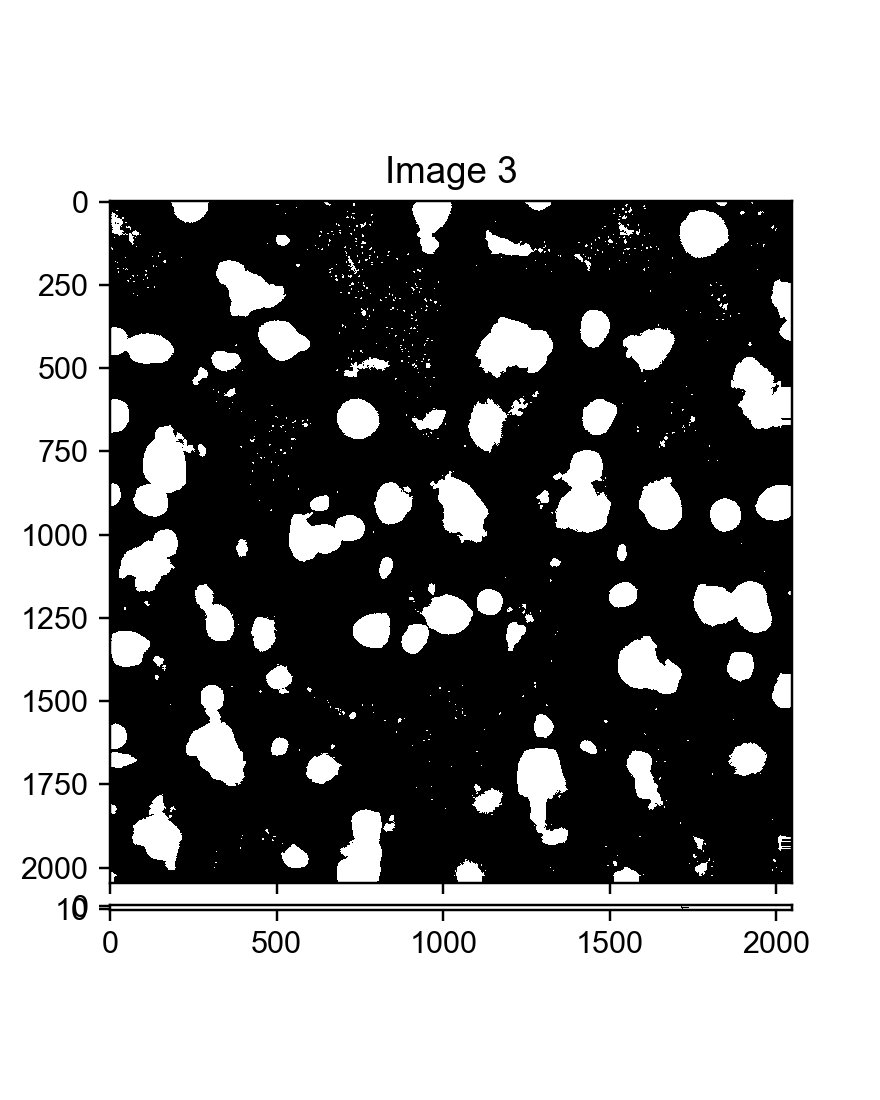

In [7]:
visual_tools.imshow_mark_3d_v2([polyt_im, waterIm, waterMask])

<IPython.core.display.Javascript object>


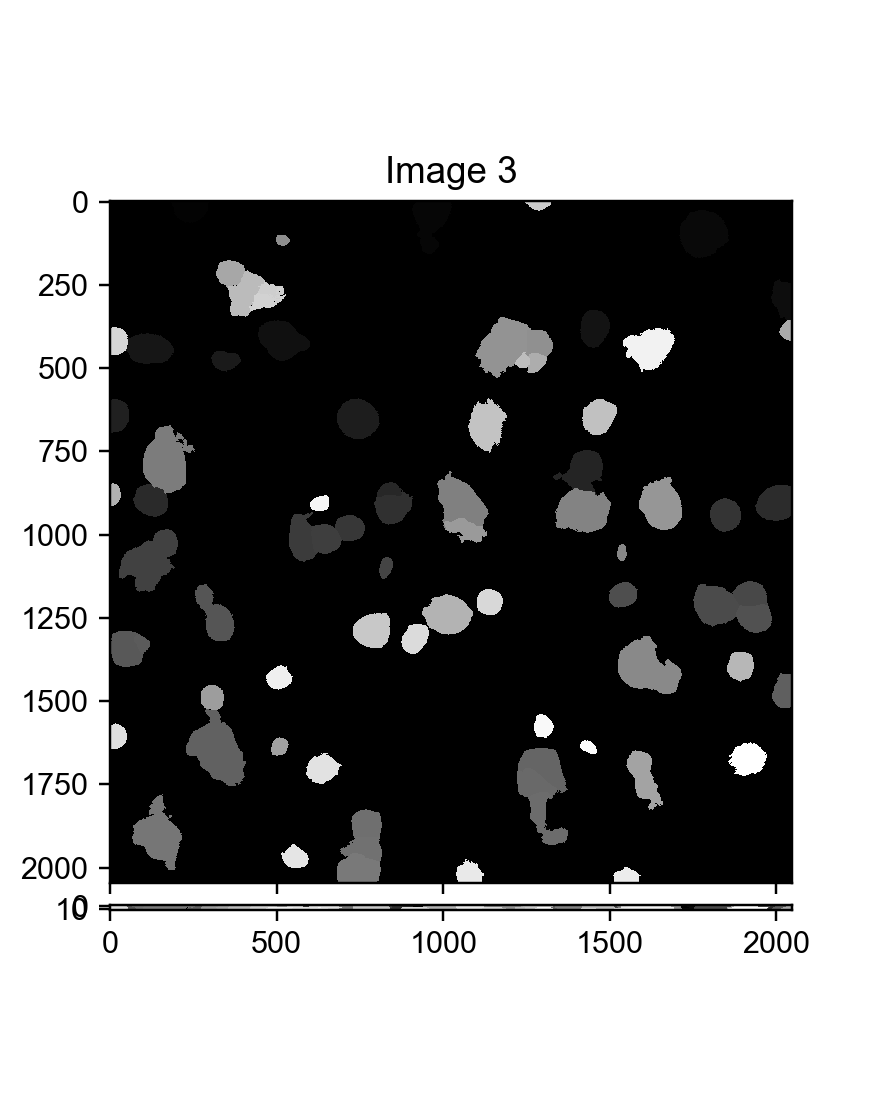

In [8]:
visual_tools.imshow_mark_3d_v2([polyt_im, corr_labels3d, new_labels, corr_labels3d==1])